# RNN bidireccional para POST

Analizaremos la estructura de una red recurrente simple. Nuestro objetivo será construir un modelo del lenguaje que tome como cadena de entrada una secuencia de palabras $w_1,...,w_T$ y cuya salida sean las etiquetas POS $s_1, ..., s_T$ que mejor describan la cadena de entrada. Para esto, buscaremos estimar la probabilidad:

$$p(s_1,...,s_T|w_1,....,w_T)$$

Para realizar esta probabilidad utilizaremos una arquitectura de red neuronal recurrente (RNN) y bidireccional. En primer lugar definiremos algunas funciones para manejar el texto.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
from preprocessing import preprocess
from itertools import chain

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

### Procesamiento de corpus

Al igual que con modelos del lenguaje más tradicionales, tomamos un corpus e indexamos las palabras con valores numéricos, con el objetivo de que sea más fácil manejarlas.

Asimismo, contamos con una cadena de etiquetas POS, las cuáles corresponden a las clases de cada una de las oraciones de entrada; es decir, cada cadena de etiquetas le corresponde una cadena de palabras de la misma longitud. De igual forma, pasaremos las etiquetas a indices numéricos.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come']

#Etiquetas POS
tags = ['DA NC V DD NC', 'DD NC V', 'DA NC V DA NC', 'DD NC V NC', 'DA NC V', 'DA NC V NC', 'DD NC V']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

#Vocabulario de emisiones
ems = vocab()
#Se susituyen las emisiones por sus índices numéricos
ems_idx = list(text2numba(tags,ems))

print(cads_idx)
print(ems_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10], [0, 1, 2], [0, 11, 2, 10], [3, 11, 2]]
[[0, 1, 2, 3, 1], [3, 1, 2], [0, 1, 2, 0, 1], [3, 1, 2, 1], [0, 1, 2], [0, 1, 2, 1], [3, 1, 2]]


Una vez realizado esto, podemos crear los pares de entrenamiento. En este caso, simplemente alinearemos la cadena de palabras con sus etiquetas correspondientes.

In [3]:
#Pares de entrenamiento
pairs = [list(zip(a,b)) for a,b in zip(cads_idx,ems_idx)]
print(pairs)

[[(0, 0), (1, 1), (2, 2), (3, 3), (4, 1)], [(3, 3), (5, 1), (6, 2)], [(0, 0), (5, 1), (7, 2), (8, 0), (9, 1)], [(3, 3), (1, 1), (2, 2), (10, 1)], [(0, 0), (1, 1), (2, 2)], [(0, 0), (11, 1), (2, 2), (10, 1)], [(3, 3), (11, 1), (2, 2)]]


### Entrenamiento de la red

Para construir la RNN bidireccional definiremos una arquitectura simple con celdas vanilla:

1) Incorporaremos una capa de embedding. En esta se tomará un one-hot $s^{(t)}$ que represente a una palabra $w_t$. Definiremos una matriz que guarde los vectores de embedding, $C$ de $d\times N$, donde $d$ es la dimensión de los embeddings y $N$ el tamaño del vocabulario. Así, la capa de embedding estará definida por $$x = Cs^{(t)}$$

2) Las celdas bidireccionales son independientes entre sí (pero dependientes de la entrada y la salida). Por facilidad, ambas celdas tendrán la misma dimensión $m$, pero las matrices que la parámetros que la definen (matrices de pesos y bias) son distintas. La celda de avance se definirá  como:

$$h_{\rightarrow t} = \tanh(V_{\rightarrow}h_{t-1} + U_{\rightarrow}x + b_{\rightarrow})$$

Por su parte, la celda de retroceso será:

$$h_{\leftarrow t} = \tanh(V_{\leftarrow}h_{t+1} + U_{\leftarrow}x + b_{\leftarrow})$$ 

Las celdas de avance y retroceso lucen parecidas, sin embargo, los parámetros seránn distintos; asimismo, la celda de avance tomará la celda en el estado anterior, mientras que la de avance tomará la celda en el estado siguiente..

3) La capa de salida se conformará por la función Softmax. Así, la definimos como $$\phi(x) = Softmax(Wh_t + c)$$

En primer lugar, inicializamos los parámetros de la red.

In [4]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = len(idx)
#El total de clases que arrojará
output_dim = len(ems)

#Dimensiones de los vectores-palabra
dim = 2
cell_dim = 3

#Embedding
C = np.random.randn(dim,nn_input_dim) / np.sqrt(nn_input_dim)

#Capa oculta
#Celda forward
V_for = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
#Celda backward
V_back = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)

#Capa oculta, entrada
#Celda forward
U_for = np.random.randn(cell_dim,dim) / np.sqrt(dim)
b_for = np.zeros(cell_dim)

#Celda backward
U_back = np.random.randn(cell_dim,dim) / np.sqrt(dim)
b_back = np.zeros(cell_dim)

#Capa de salida
W = np.random.randn(output_dim,2*cell_dim) / np.sqrt(cell_dim)
c = np.zeros(output_dim)

### Predicción de etiquetado POS

Una vez entrenado el modelo, definimos una función (forward) que corra la red sobre una cadena de entrada. Esta función devolverá la probabilidad de las etiquetas POS en cada estado y dado la palabra de entrada en ese estado.

In [5]:
it = 100
lr = 0.01

for t in range(it):
    
    #Avance
    for seq in pairs:
        #Inicializaciopn de estados
        h_for = np.zeros((len(seq)+1,cell_dim))
        #Inicialización de estados
        h_back = np.zeros((len(seq)+1,cell_dim))
        
        #Avance
        for t,w in enumerate(seq):
            #FORWARD
            #Embedding
            x = C.T[w[0]]
                        
            #VANILLA CELLS
            #Avance
            act_for = np.dot(V_for,h_for[t]) + np.dot(U_for,x) + b_for
            h_for[t+1] = np.tanh(act_for)
              
        #Retroceso
        for t,w in enumerate(seq[::-1]):
            #FORWARD
            #Embedding
            x = C.T[w[0]]
            
            #VANILLA CELLS
            #Retroceso
            act_back = np.dot(V_back,h_back[t]) + np.dot(U_back,x) + b_back
            h_back[t+1] = np.tanh(act_for)
        
        #OPUTPUT & BACKPROP
        for t, w in enumerate(seq):
            #Avance+Retroceso
            h = np.concatenate((h_for[t+1], h_back[t+1]), axis=None)
            
            #capa de salida
            preAct = np.exp(np.dot(W,h) + c)
            #Softmax
            probs = preAct/preAct.sum(0)
            
            #BACK-PROP
            #Variable de salida
            d_out = probs
            d_out[w[1]] -= 1
            
            #Variable de celdas
            d_h = (1-h**2)*np.dot(W.T,d_out)
            
            #Variable de embedding
            d_emb = np.dot(U_for.T,d_h[:cell_dim]) + np.dot(U_back.T,d_h[cell_dim:])

            #Jacobianas
            dW = np.outer(d_out,h)
            #Avance
            dV_for = np.outer(d_h[:cell_dim], h_for[t+1])
            dU_for = np.outer(d_h[:cell_dim], x)
            #Retroceso
            dV_back = np.outer(d_h[cell_dim:], h_back[t+1])
            dU_back = np.outer(d_h[cell_dim:], x)

            #Gradientes descendientes
            W -= lr*dW
            c -= lr*d_out
            
            V_for -= lr*dV_for
            V_back -= lr*dV_back
            
            U_for -= lr*dU_for
            b_for -= lr*d_h[:cell_dim]
            U_back -= lr*dU_back
            b_back -= lr*d_h[cell_dim:]
            
            C.T[w[0]] -= lr*d_emb

Una vez entrenado el modelo, definimos una función (forward) que corra la red sobre una cadena de entrada.

In [6]:
def forward(sent, h0_for = np.zeros(cell_dim), h0_back = np.zeros(cell_dim)):
    sent = [idx[i] for i in sent.split()]
    prob_tot = np.zeros((len(sent),output_dim))
    
    #Inicializaciopn de estados
    h_for = np.zeros((len(sent)+1,cell_dim))
    #Inicialización de estados
    h_back = np.zeros((len(sent)+1,cell_dim))

    #Asignación de valores iniciales
    h_for[0] = h0_for
    h_back[0] = h0_back

    #Avance
    for t,w in enumerate(sent):
        #FORWARD
        #Embedding
        x = C.T[w]

        #VANILLA CELLS
        #Avance
        act_for = np.dot(V_for,h_for[t]) + np.dot(U_for,x) + b_for
        h_for[t+1] = np.tanh(act_for)

    #Retroceso
    for t,w in enumerate(sent[::-1]):
        #BACKWARD
        #Embedding
        x = C.T[w]

        #VANILLA CELLS
        #Retroceso
        act_back = np.dot(V_back,h_back[t]) + np.dot(U_back,x) + b_back
        h_back[t+1] = np.tanh(act_for)

    #OPUTPUT & BACKPROP
    for t, w in enumerate(sent):
        #Avance+Retroceso
        h = np.concatenate((h_for[t+1], h_back[t+1]), axis=None)

        #capa de salida
        preAct = np.exp(np.dot(W,h) + c)
        #Softmax
        probs = preAct/preAct.sum(0)

        #Se almacenan las probabilidades
        prob_tot[t] = probs
        
    return np.concatenate((h_for,h_back), axis=1), prob_tot       

Finalmente, podemos aplicar la red a una cadena para obtener las etiquetas POS que mejor predigan la cadena de entrada.

In [9]:
#Vocabulario para recuperar POS por medio de índices
post = {v:k for k,v in ems.items()}

#Forwarde de la red
H,p = forward('el perro come el gato')

#Buscamos las etiquetas que maximicen la probabilidad
print([post[i] for i in np.argmax(p, axis=1)])

['DA', 'NC', 'V', 'DA', 'V']


### Ploteo de los embeddings

Además de obtener una probabilidad de cadenas, el modelo que hemos descrito aprende representaciones vectoriales de la palabra o embeddings. Al igual que el modelo de Word2Vec, podemos ocupar una arquitectura recurrente para obtener embeddings de palabra. Aquí hemos descrito una versión muy sencilla de esto. Modelos más complejos son CoVe (McCann, 2017) o ELMo (Peters et al., 2018).

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from operator import itemgetter

#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    #plt.show()

#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]

Así, la visualización de los datos es la siguiente:

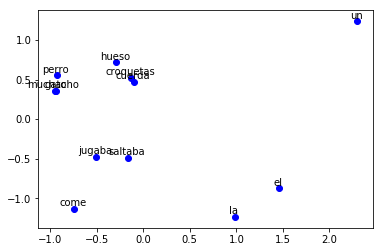

In [11]:
plot_words(C.T,label)

### Calculo de similitud

Para calcular la similitud entre vectores, se puede utilizar la distancia eculideana o bien el coseno. En NLP el coseno es una forma común de determinar la similitud entre vectores. Este se define como:

$$\cos(x,y) = \frac{x\cdot y}{||x|| ||y||}$$

Asimismo, para simplificar el calculo del coseno se pueden normalizar los vectores, dividiéndolos entre sus normas. Así, para cada vector $x$ su norma es $||x||=1$, lo que simplifica la ecuación anterior a:

$$\cos(x,y) = x\cdot y$$

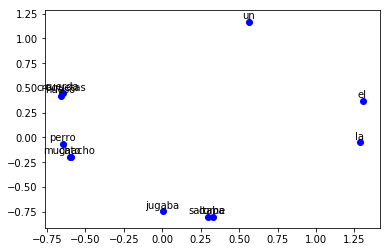

In [12]:
#Normalización de los vecotores
C_norm = (C/np.array([np.linalg.norm(w) for w in C.T])).T

#Ploteo
plot_words(C_norm,label)

In [13]:
#Palabra objetivo
obj_word = C_norm[idx['perro']]

#Búsqueda de palabras más similares
for w,v in idx.items():
    #Calcula la distancia coseno
    print(w,'\t', np.dot(C_norm[v], obj_word) )

el 	 -0.9951178822486634
perro 	 1.0
come 	 0.25647817432429054
un 	 -0.49372522716176764
hueso 	 0.884458716250909
muchacho 	 0.989731240835349
jugaba 	 0.5561126067874839
saltaba 	 0.2851407229611602
la 	 -0.8679586132903605
cuerda 	 0.8682583902289329
croquetas 	 0.8708034658518443
gato 	 0.9899273588438126


### Visualización de las celdas recurrentes

Las celdas recurrentes guardan información tanto de los vectores de entrada como de la red en estados anteriores. Estas celdas tienen información importante que le permite a la red decidir la distribución de salida en un estado dado. Algunos modelos de representación vectorial (word embeddings) han aprovechado la información aquí almacenada para producir vectores de palabraS; sistemas como CoVe toman en cuenta estas celdas para "contextualizar" los embeddings.

Lo primero que haremos es definir un función que, además de devolver la probabilidad de salida, regrese cada una de las celdas recursivas en cada estado $t$. Así, obtendremos una matriz $H$ donde cada renglon será una celda vanilla. Podemos definir esta matriz por sus renglones como:

$$H_{t} = g(Vh^{(t-1)} + Ux^{(t)} + b)$$

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.78619031  0.62818016  0.9290269  -0.99941756 -0.95405707 -0.8390162 ]
 [ 0.40366604  0.97703303 -0.5354598  -0.99941756 -0.95405707 -0.8390162 ]
 [-0.79244089  0.96910621 -0.87368468 -0.99941756 -0.95405707 -0.8390162 ]
 [-0.99215239 -0.28683244 -0.44267622 -0.99941756 -0.95405707 -0.8390162 ]
 [-0.99941756 -0.95405707 -0.8390162  -0.99941756 -0.95405707 -0.8390162 ]]


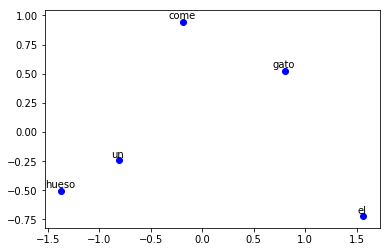

In [18]:
ex_sent = 'el gato come un hueso'
H_s, p_s = forward(ex_sent)
print(H_s)

plot_words(H_s[1:],ex_sent.split())
plt.show()

Entonces, dada una cadena, se obtendrá una celda vanilla para cada palabra en la cadena. De esta forma, podemos pensar que esta celda representa a la palabra  y su historia (las palabras que lo anteceden). Podemos visualizarlos, entonces, en un espacio vectorial.

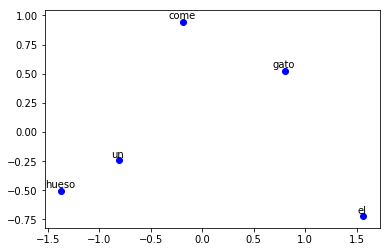

In [19]:
ex_sent = 'el gato come un hueso'
H_s, p_s = forward(ex_sent)

plot_words(H_s[1:],ex_sent.split())
plt.show()

Se puede ver cómo varían las celdas vanillas. Algunas de estas guardan cierta relación. Sin embargo, una interpretación precisa puede resultar complicada.

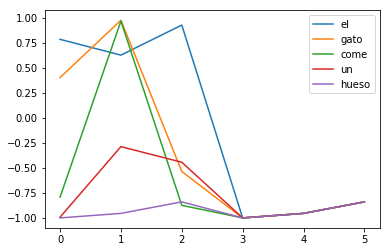

[[ 0.78619031  0.62818016  0.9290269  -0.99941756 -0.95405707 -0.8390162 ]
 [ 0.40366604  0.97703303 -0.5354598  -0.99941756 -0.95405707 -0.8390162 ]
 [-0.79244089  0.96910621 -0.87368468 -0.99941756 -0.95405707 -0.8390162 ]
 [-0.99215239 -0.28683244 -0.44267622 -0.99941756 -0.95405707 -0.8390162 ]
 [-0.99941756 -0.95405707 -0.8390162  -0.99941756 -0.95405707 -0.8390162 ]]


In [20]:
plt.plot(H_s[1:].T, '-')
plt.gca().legend(ex_sent.split())
plt.show()
print(H_s[1:])